# Dataset: Pairwise GNN approach

Get tracksters from a certain neighbourhood.

Construct a graph of the neighbourgood (or just a binary pair?) based on layer-clusters.

Classify cut-edges based on the node data.
Node data is enriched using message passing.

Maybe it's easier to start with binary pairs - although not computationaly optimal.

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [1]:
import uproot
import numpy as np
import awkward as ak
import networkx as nx

import matplotlib.pyplot as plt

from reco.event import get_candidate_pairs
from reco.graphs import create_graph
from reco.dataset import match_trackster_pairs, PointCloudPairs

from reco.plotting import plot_graph_3D


plt.style.use('seaborn-whitegrid')

data_root = "data/"
raw_dir = "/Users/ecuba/data/multiparticle_complet"

file_name = "~/data/multiparticle_complet/new_ntuples_14992862_991.root"
tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [2]:
eid = 0

c_pairs, dst_map = get_candidate_pairs(tracksters, graphs, eid, max_distance=15)

gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=20,
    distance_threshold=15,
)

build supergraph

In [3]:
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
vi = tracksters["vertices_indexes"].array()[eid]


ca, cb, _ = gt_pairs[0] # c_pairs for candidate pairs

ca_lc = set(vi[ca])
cb_lc = set(vi[cb])

cvx = ak.flatten([vx[ca], vx[cb]])
cvy = ak.flatten([vy[ca], vy[cb]])
cvz = ak.flatten([vz[ca], vz[cb]])
cve = ak.flatten([ve[ca], ve[cb]])
cvi = ak.flatten([vi[ca], vi[cb]])

G = create_graph(cvx, cvy, cvz, cve, trk_lc_index=cvi, N=1, higher_e=True)

for edge in G.edges:
    a, b = edge
    ai = G.nodes[a]["index"]
    bi = G.nodes[b]["index"]
    if (ai in ca_lc and bi in cb_lc) or (bi in ca_lc and ai in cb_lc):
        G.edges[edge]["color"] = "green"
        

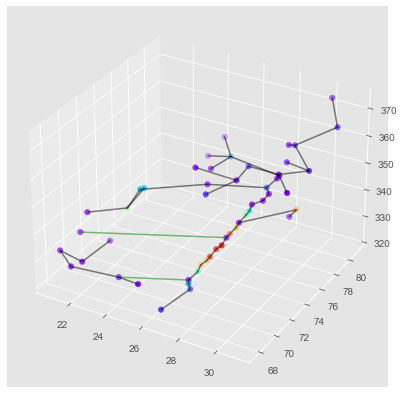

In [4]:
plot_graph_3D(G, cve)

# The dataset

Following DGCNN, the graphs are constructed dynamically, therefore, the sample data should contain a two point clouds and a label.

In [5]:
ds = PointCloudPairs(
    "10mp",
    data_root,
    raw_dir,
    N_FILES=5,
    balanced=False,
    MAX_DISTANCE=15,
    ENERGY_THRESHOLD=20,
)

In [25]:
ds

<PointCloudPairs len=39408 max_distance=15 balanced=False energy_threshold=20>

label: tensor(0.)


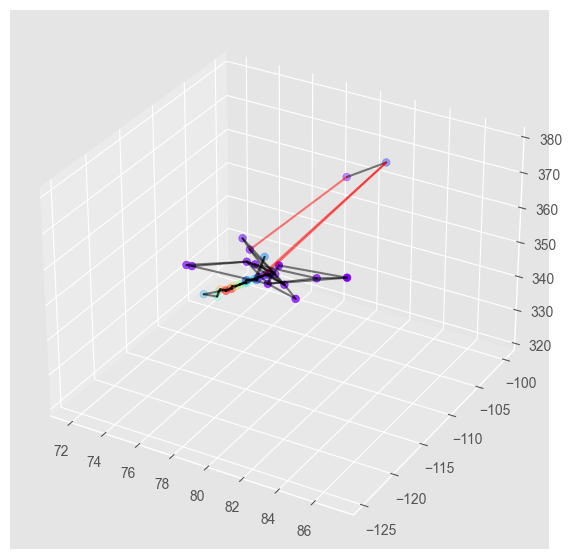

In [72]:
# pick a sample
x1, x2, label = ds[100]

# merge the point clouds
x = x1[0] + x2[0]
y = x1[1] + x2[1]
z = x1[2] + x2[2]
e = x1[3] + x2[3]

# build index
index = [0] * len(x1[0]) + [1] * len(x2[0])
print("label:", label)

# build the graph
G = create_graph(x, y, z, e, trk_lc_index=index, N=2, higher_e=True)

# color the cut edges
for edge in G.edges:
    a, b = edge
    if (G.nodes[a]["index"] != G.nodes[b]["index"]):
        G.edges[edge]["color"] = "green" if label == 1 else "red"

# plot it
plot_graph_3D(G, e)